# Regression: Predicting fuel efficiency

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-w60to6ud
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-w60to6ud
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0c185f9ef2d3eed3d6afa48babc4b3e30dee1eb3f_-cp36-none-any.whl size=143515 sha256=f86d3c01aa1bf005ba79b6cfb3489fb6f1f8e2e3defee5f3fb9c4a7f68f525b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-1tw1382j/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

## The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).



### Get the data
First download the dataset.

In [5]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

Import it using pandas

In [6]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Clean the data

The dataset contains a few unknown values.

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

One simple option is to drop those rows.

In [8]:
dataset = dataset.dropna()

The `"Origin"` column is really categorical, not numeric. So convert that to a one-hot:

In [9]:
dataset['Origin'] = dataset['Origin'].map(lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))

In [10]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Split the data into train and test

Now split the dataset into a training set and a test set.

In [11]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

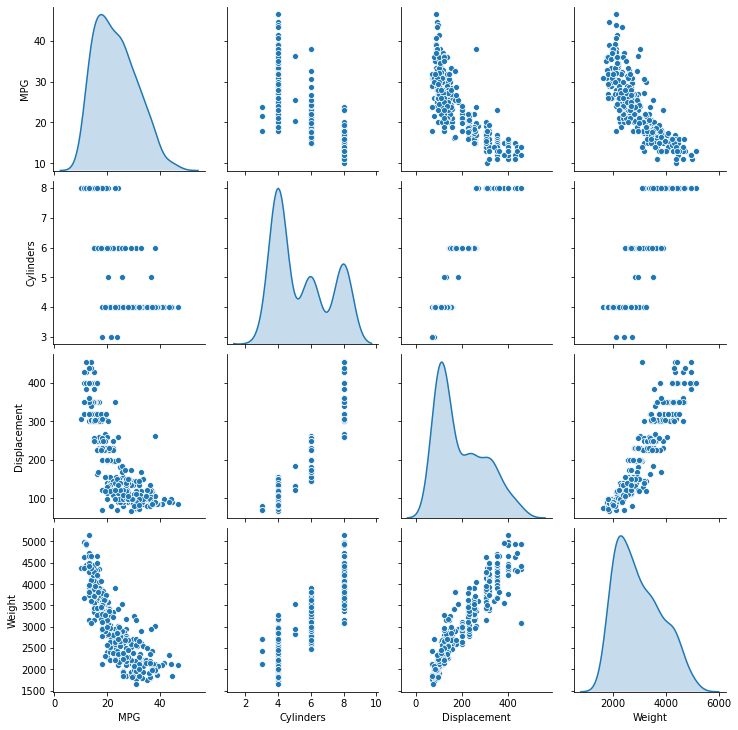

In [12]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Also look at the overall statistics:

In [13]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [14]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [15]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

## The model

In [16]:
#INSERT YOUR CODE TO BUILD AND COMPILE THE MODEL HERE
def MPG_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model
#YOU CAN ALSO CHANGE THE MODEL TRAINING PARAMETERS BELOW

In [17]:
model = MPG_model()
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=15)

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [18]:
EPOCHS = 500

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:561.6443,  mae:22.4960,  mse:561.6443,  val_loss:556.2937,  val_mae:22.3381,  val_mse:556.2937,  
....................................................................................................
Epoch: 100, loss:6.2122,  mae:1.7726,  mse:6.2122,  val_loss:8.3583,  val_mae:2.1502,  val_mse:8.3583,  
.................

Visualize the model's training progress using the stats stored in the `history` object.

In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
112,6.015887,1.728465,6.015887,8.473057,2.239840,8.473057,112
113,6.074881,1.721352,6.074881,8.300221,2.172947,8.300221,113
114,5.957830,1.711943,5.957830,8.241160,2.192213,8.241160,114
115,6.047573,1.726214,6.047573,8.250978,2.195709,8.250978,115
116,6.022691,1.709685,6.022691,8.303297,2.175691,8.303297,116


In [20]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

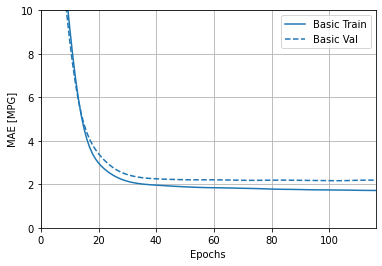

In [21]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

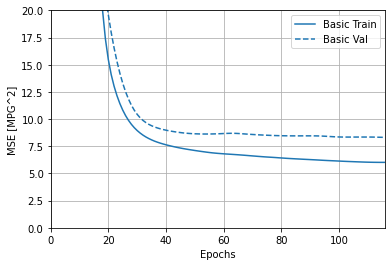

In [22]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

Now determine how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [23]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.6270 - mae: 1.8168 - mse: 5.6270
Testing set Mean Abs Error:  1.82 MPG


### Make predictions

Finally, predict MPG values using data in the testing set:

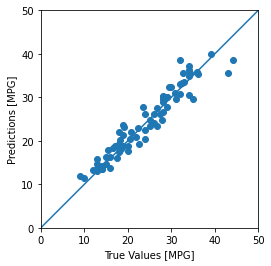

In [24]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
